In [25]:
pip install Sastrawi

In [26]:
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize


# Sastrawi (stemming Indonesia)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Clustering
from sklearn.cluster import KMeans

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation

# Visualization
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [27]:
df = pd.read_csv("dataset_manual_label.csv", encoding='latin1', sep=';')

df.info()

df.isna().sum()

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               250 non-null    object
 1   text_cleaned_full  250 non-null    object
 2   manual             250 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


,text,text_cleaned_full,manual
0,kepo bgt adekkkk??????????????,kepo adekkkk,negatif
1,"buah jatuh se pohon "" nya????",buah jatuh se pohon nya,negatif
2,Cushion Nya kegelapan ga sihhh??,cushion nya kegelapan sihhh,negatif
3,LU APAIN PONI BOCIL ITU KAK JENNN?!!! KENAPA L...,lu apain poni bocil kak jennn kenapa lu buat s...,negatif
4,mayi gamau kalah cantik sama mamanya????,mayi gamau kalah cantik sama mamanya,negatif


In [28]:
df = df[df['text_cleaned_full'].notna()].copy()
df.reset_index(drop=True, inplace=True)

print("Jumlah data setelah cleaning:", len(df))


Jumlah data setelah cleaning: 250


In [29]:
# Stopwords Indonesia
stopword_factory = StopWordRemoverFactory()
STOP_WORDS = set(stopword_factory.get_stop_words())

# Stemmer
stemmer = StemmerFactory().create_stemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOP_WORDS]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)


In [30]:
df['clean_text'] = df['text_cleaned_full'].apply(preprocess)

df[['text_cleaned_full', 'clean_text']].head()


,text_cleaned_full,clean_text
0,kepo adekkkk,kepo adekkkk
1,buah jatuh se pohon nya,buah jatuh se pohon nya
2,cushion nya kegelapan sihhh,cushion nya gelap sihhh
3,lu apain poni bocil kak jennn kenapa lu buat s...,lu apain poni bocil kak jennn lu buat sungsang...
4,mayi gamau kalah cantik sama mamanya,mayi gamau kalah cantik sama mama


In [31]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

df['text_length'].describe()


,text_length
count,250.000000
mean,4.492000
std,3.059309
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,22.000000


In [32]:
tfidf = TfidfVectorizer(
    max_df=0.9,
    min_df=3,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(df['clean_text'])

X_tfidf.shape


(250, 83)

In [33]:
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)


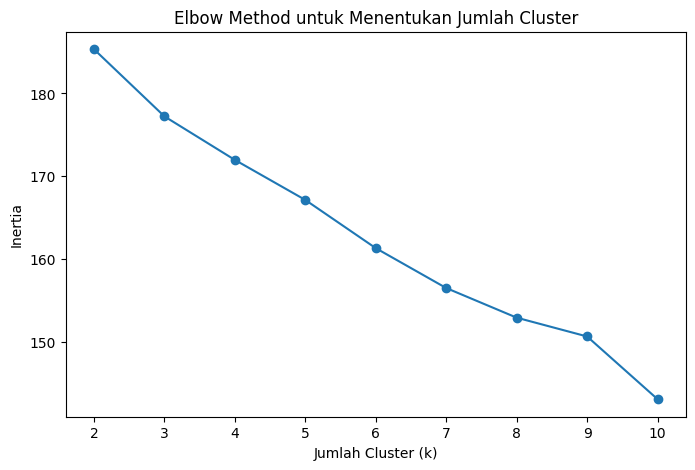

In [34]:
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.show()


In [35]:
k_optimal = 5

kmeans = KMeans(
    n_clusters=k_optimal,
    random_state=42,
    n_init=10
)

df['cluster'] = kmeans.fit_predict(X_tfidf)

df[['manual', 'cluster']].head()


,manual,cluster
0,negatif,2
1,negatif,2
2,negatif,2
3,negatif,2
4,negatif,1


In [36]:
df['cluster'].value_counts().sort_index()

,count
cluster,
0,9
1,41
2,164
3,23
4,13


In [37]:
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(k_optimal):
    print(f"\nCluster {i}:")
    for ind in order_centroids[i, :10]:
        print(terms[ind])


Cluster 0:
jen
kamar
kulit
gue
lu
cantik
sungsang
gua
mama
poni nya

Cluster 1:
mayi
cantik
mayi cantik
mayi minta
minta
mau
poni
nya
siapa
mama

Cluster 2:
poni
nya
kak
timephoria
lu
mayii
panjang
si
dah
cakep

Cluster 3:
kamar
poni kamar
apa
sendiri
poni
pinter
til
ngomong
motong
kak

Cluster 4:
lucu
kamar
bgtt
blonde
sehat
muka
serah
minta
poni
mayi


In [38]:
count_vect = CountVectorizer(
    max_df=0.9,
    min_df=3
)

X_count = count_vect.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(
    n_components=k_optimal,
    random_state=42
)

lda.fit(X_count)


LatentDirichletAllocation(n_components=5, random_state=42)

In [39]:
feature_names = count_vect.get_feature_names_out()

def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopik {idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(lda, feature_names)



Topik 0:
mayi, cantik, cakep, minta, dah, sibuk, siapa, mama, mau, cute

Topik 1:
poni, nya, kak, panjang, potong, tau, lama, kulit, lu, buat

Topik 2:
blonde, cushion, gelap, putih, muka, apa, mayiii, mamari, kulit, nang

Topik 3:
lucu, lu, mayii, jen, timephoria, gemesss, bgtt, sama, till, gw

Topik 4:
kamar, makin, si, ngomong, kenal, pinter, poni, siapa, sendiri, gue


In [40]:
df['topic'] = lda.transform(X_count).argmax(axis=1)

df[['manual', 'cluster', 'topic']].head()

,manual,cluster,topic
0,negatif,2,0
1,negatif,2,1
2,negatif,2,2
3,negatif,2,1
4,negatif,1,0
